# Has our average body temperature evolved since it was labeled as 98.6 degrees in 1868?  

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm

#### Steps

1. Use various methods to check normality with the temperature data
2. Evaluate sample size, indepedence, and random nature of sample
3. Use bootstraping & frequentists methods to compute the current average, and if this change is stastically signficant, or due to chance.
4. Experiment with sample size, and see what happens to the probability stastics when you reduce the sample from 130 to 10 and compute both a z & t stastistic
5. Explore what it means to have an "abnormal temperature" by exploring the confidence intervals using the bootstrapping & frequentists methods
6. Explore the difference of normal temperatures between male and females

## Imports

In [1]:
#imports & upload data

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import ttest_1samp
import seaborn as sns
import math
sns.set()

df = pd.read_csv('data/human_body_temperature.csv')

#### Look at imported data frame to understand columns and data...

In [2]:
df.shape
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


## Forumlas



* Standard Devation:

$ s =\sqrt{\frac{1}{N-1}\sum_{i=1}^N (x_i - \bar{x})^2 }$

* Standard Sample Error:

$ \text{s}_\bar{x}\ = \frac{s}{\sqrt{n}} $

* Confidence intervals for z-score:

$\left(\bar{x} - z^* {\sigma \over \sqrt{n}}, \bar{x} + z^* {\sigma \over \sqrt{n}}\right)$

* Confidence interval for t-score (less than 30 samples): 

$\left(\bar{x} - t^* {s \over \sqrt{n}}, \bar{x} + t^* {s \over \sqrt{n}}\right)$

## Functions

In [3]:
#ECDF function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y= np.arange(1, n+1)/ n

    return x, y

#Bootstrap functions that creates replicates for n size of sample

#MAIN function:takes in a number of samples plus data & Function
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

#function to convert data to a sample
def bootstrap_replicate_1d(data,func):
    """Generate bootstrap replicate of 1d data"""
    bs_sample= np.random.choice(data, len(data))
    return func(bs_sample)

## 1. Checking if the Body Temperatures are Normalized
#### Histogram Method:


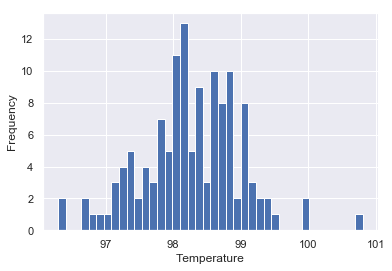

In [4]:
#Show a histogram of body temps
x= plt.hist(df["temperature"], bins=40)#tried different size bins (15,20,40,50) to get a better picture
x= plt.xlabel("Temperature")
x= plt.ylabel("Frequency")
plt.show()

#### ECDF Method:

Comparing the ECDF with what the data's normal distribution *would* look like

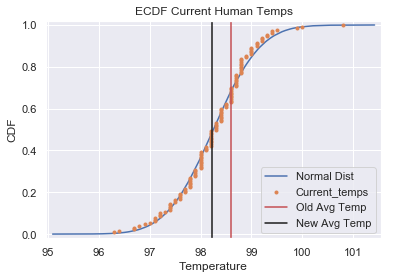

In [5]:
# Comparing the temps to a normal distribution:
mu= np.mean(df["temperature"])
sigma= np.std(df["temperature"])

#Compute the ECDF of the current temp data
x, y = ecdf(df["temperature"]) #ecdf function listed in the beginning

# Create a normal distribution with the current temperature's mu and sigma
normal= np.random.normal(mu, sigma, size =100000)

# Get the CDF of the samples and of the data
x_theor, y_theor= ecdf(normal) #ecdf function listed in the begginning

# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Temperature')
_ = plt.ylabel('CDF')
plt.margins(.02) #keeps data off graph edges
plt.title ("ECDF Current Human Temps")
plt.axvline(98.6, color='r')
plt.axvline(98.23, color='k')
plt.legend(('Normal Dist', 'Current_temps','Old Avg Temp','New Avg Temp'), loc='lower right')

plt.show()

*From this graph we can see that the higher temperatures look to be a bit under-represented, but it is close*

## 2. Evaluating Conditions: Sample Size, Independence, Random Samples

#### Sample Size: 

There are a 130 samples which is greater than 30. Samples become more accurate when n exceeds 30 and will also allow us to use the z-table (Although, we will experiment with using both z & t stastics on different sample sizes to see the effect) 

In [6]:
len(df.temperature)

130

#### Independence:

Independence can be assumed because of the 10% rule, which states independence can be assumed if the sample is less than 10% of the total population. This sample of 130 will most certainly to be assumed to be less than 10% of the total population.

#### Random Samples:

This data was derived from a dataset presented in Mackowiak, P. A.,
Wasserman, S. S., and Levine, M. M.  (1992), "A Critical Appraisal of
98.6 Degrees F, the Upper Limit of the Normal Body Temperature, and
Other Legacies of Carl Reinhold August Wunderlich," _Journal of the
American Medical Association_, 268, 1578-1580 where appropiate measures were taken to generate random samples

## 3. Evaulate: is the new average stastically sigificant?
#### Utilize the Following:
* One sample bootstrap test
* One sample frequentist test using z-table
* One sample frequentist test using t-table

#### Stating the Hypothesis & Alpha:
* Null hypothesis 
>$H_0: \mu = 98.6 $
* Alternative hypothesis 
> $ H_1: \mu \neq 98.6 $
* Significance Level
> $ {\alpha = .05} $

#### Current Average Temperature

In [7]:
#Change the pandas series into an array for my functions will work
current_temp = df["temperature"].values

#Calculate the mean of the current temperature data
current_temp_mean= np.mean(current_temp)
print (f"The Current Temperatrue average is: {current_temp_mean}")

The Current Temperatrue average is: 98.24923076923075


#### Bootstrap Hypothesis Test

*Since, we don't possess the data from the original 1868 study, this will be a one-sample bootstrap test where I will manufacture a data set (using replacement) from our current sample reflecting the same average as the 1868 mean.*

In [8]:
# STEP 1: convert the data in the current temperature column to refelct the mean of  98.6 ∘ from 1868
translated_temp_data = current_temp - current_temp_mean + 98.6

# STEP 2: Take bootstrap replicates of the temps translated temperatures
bs_replicates = draw_bs_reps(translated_temp_data, np.mean, 100000) #100000 samples drawn with size of 130

# STEP 3: Compute the p-value or fraction of replicates that are less than the observed current mean
p1 = np.sum(bs_replicates <= current_temp_mean) / len(bs_replicates) 

# STEP 4: Print the p-value
print(f'p = {p1:.5f}')

if p1 <0.05: # alpha value is 0.05 or 5%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")

p = 0.00000
We reject the null hypothesis


#### One-Sample Frequentist Test (Z-stastistic)
*We need to use a z-test since our sample size is greater than 30 and independent samples*

In [9]:
#intializing one-sample z-test

ztest ,pval4 = stests.ztest(current_temp, x2=None, value=98.6)
print(float(pval4))
if pval4<0.05: # alpha value is 0.05 or 5%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")

4.9021570141012155e-08
We reject the null hypothesis


#### One-Sample Frequentist Test (T-stastistic)
*Will now experiment with the t-test to see if there is a difference, even though the z-stastistic is the most appropiate measure*

In [10]:
tset, pval3 = ttest_1samp(current_temp, 98.6)
print(f"P-values:{pval3:.5f}")
if pval3 < 0.05:    # alpha value is 0.05 or 5%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")

P-values:0.00000
We reject the null hypothesis


*It looks like in all cases the null hypothesis was rejected. However, it should be noted that the p-value was expeptionally small in the bootstrap & the t-stastistic test*

## 4. Experiment with Sample Size
*What will happen to the probability when reducing the sample size from 130 to 10?*

#### Utilize the Following:
* One sample frequentist test using z-table
* One sample frequentist test using t-table

#### Taking a Random Sample of 10 from the current temperature data set

In [11]:
#RANDOM SAMPLE:
random_10 = df['temperature'].sample(n=10, random_state=1)
random_10= random_10.values #turn the random sample into an array

#### Z-Test 10-samples 
*Improper use of z-stastistic with <30 samples*

In [12]:
ztest ,pval = stests.ztest(random_10, x2=None, value=98.6)
print(float(pval))
if pval < 0.05:    # alpha value is 0.05 or 5%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")

0.04931956555099463
We reject the null hypothesis


#### T-Test 10-samples
*Proper use of t-stastistic with <30 samples*

In [13]:
tset, pval1 = ttest_1samp(random_10, 98.6)
print(f"P-values:{pval1:.3f}")
if pval1 < 0.05:    # alpha value is 0.05 or 5%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")

P-values:0.081
We accept the null hypothesis


*The first acceptance of the null hypothesis was when using the T-test with 10 samples. The Z-test still rejected the null hypothesis which is curious because the z-stat was not a proper application given the sample size, but the t-test was a correct application. Clearly the null is rejected based on all 6 tests, so perhaps the t-test was reflecting the limited information a sample size of ten provides*

## 5. Explore what it means to have an "abnormal temperature"  
*We will examine this question using a 95% confidence interval*
#### Utilize the Following:
* Confidence intervals using the boostrap method on the original data set (not the 1868 mean of 98.6)
* Confidence intervals & margin of error using frequentist methods

#### Bootstrap Confidence Interval 

In [14]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(current_temp,np.mean, size=100000) #100,000 bootstrap samples

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

# Print the confidence interval & margin of error
print(f"The margin of error = {current_temp_mean - conf_int[:1]}")
print(f'The 95% confidence interval = {conf_int}')

The margin of error = [0.12615385]
The 95% confidence interval = [98.12307692 98.37538462]


#### Frequentist Confidence Interval

In [15]:

# Compute mean and standard deviation of the current sample: mu, sigma
n= len(current_temp)
sd = np.std(current_temp)
z= 1.96 #95% confidence interval

#Compute the 95% confidence interval
margin_er = z * (sd/math.sqrt(n))

# Print the confidence interval & margin of error
print(f"The margin of error = {margin_er}")
print(f'The 95% confidence interval = [{current_temp_mean- margin_er}, {current_temp_mean + margin_er}]')


The margin of error = 0.12555096480257902
The 95% confidence interval = [98.12367980442816, 98.37478173403333]


*Based on both confidence interval tests, we can be 95% certain that the average human temperature is somewhere between 98.12 & 98.37*

## 6. Explore if there is a difference of normal temperatures between male and females

#### Utilize the Following:
* Frequentist Z-test to test the hypothesis that the mean of men and women are the same
* Boostrap two-sample test

#### Stating the Hypothesis & Alpha:
* Null hypothesis 
>$H_0: \mu1 = \mu2 $
* Alternative hypothesis 
> $ H_1: \mu1 \neq \mu2 $
* Significance Level
> $ {\alpha = .05} $

#### First, split up the sample into male and female sections

In [16]:
#create two separate data frames filtering out males & females
females = df[df.gender == "F"]
males = df[df.gender == "M"]
females.head()

#create two arrays to use in bootstrap function
f_temps = females.temperature.values
m_temps = males.temperature.values

#### Visualizing the Difference Between Male & Female Temperatures
>* ECDF
>* Violin Plot
>* Bee-swarm

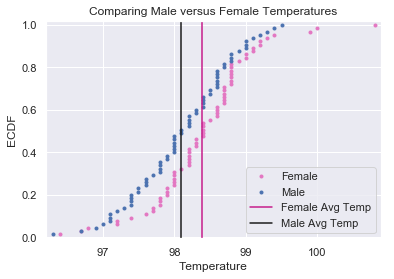

Female Average Temp is = 98.39384615384614
Male Average Temp is = 98.10461538461537


In [17]:
#ECDF Graph

#Compute the ECDF of males and females
x_f, y_f = ecdf(f_temps) #ecdf for females
x_m, y_m = ecdf (m_temps) #ecdf for males

# Plot the CDFs and show the plot
_ = plt.plot(x_f, y_f, marker='.', linestyle='none',color= 'tab:pink')
_ = plt.plot(x_m, y_m, marker='.', linestyle='none', color= "b")
_ = plt.xlabel('Temperature')
_ = plt.ylabel('ECDF')
plt.margins(.02) #keeps data off graph edges
plt.axvline(98.39, color='#c51b8a')
plt.axvline(98.10, color='k')
plt.title ("Comparing Male versus Female Temperatures")
plt.legend(('Female', 'Male', 'Female Avg Temp', 'Male Avg Temp'), loc='lower right')

plt.show()

#average temps
print (f"Female Average Temp is = {np.mean(f_temps)}")
print (f"Male Average Temp is = {np.mean(m_temps)}")

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<function matplotlib.pyplot.show(*args, **kw)>

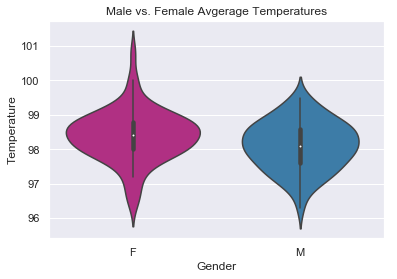

In [18]:
#Violin Plot

#Creating a color palette
my_pal = {"F": "#c51b8a", "M": "#2c7fb8"}
 
#Generate Plot
sns.violinplot(x="gender", y= "temperature", data = df, palette=my_pal)
plt.title("Male vs. Female Avgerage Temperatures")
plt.xlabel("Gender")
plt.ylabel("Temperature")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

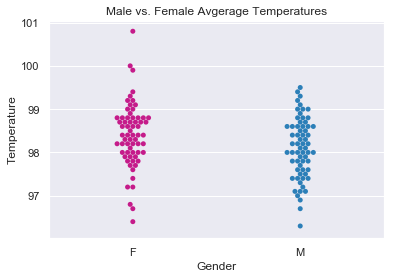

In [19]:
#Swarm Plot

sns.swarmplot( x= "gender", y= "temperature", data= df, palette=my_pal)

plt.title("Male vs. Female Avgerage Temperatures")
plt.xlabel("Gender")
plt.ylabel("Temperature")
plt.show

#### Frequentist Two-Sample Test

In [20]:
#z-test 
ztest ,pval2 = stests.ztest(males['temperature'], x2=females['temperature'], value=0,alternative='two-sided')

#results
print(f"P-value:{pval2:.3f}")
if pval2 < 0.05:    # alpha value is 0.05 or 5%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")

P-value:0.022
We reject the null hypothesis


#### Bootstrap two-sample test

In [21]:
#Compute the original difference of means:
original_diff_mean = np.mean(f_temps- m_temps)

# First, shift each array so they refelct the original current temp mean
f_temps_shifted = f_temps - np.mean(f_temps) + current_temp_mean 
m_temps_shifted = m_temps - np.mean(m_temps)+ current_temp_mean

# Compute 100,000 bootstrap replicates from shifted arrays
bs_replicates_f = draw_bs_reps(f_temps_shifted, np.mean, 10000)
bs_replicates_m = draw_bs_reps(m_temps_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_f - bs_replicates_m

# Compute and print p-value: p
p2 = np.sum(bs_replicates >= original_diff_mean) / len(bs_replicates) 

print(f'P-value = {p2}')
if p2 < 0.05:    # alpha value is 0.05 or 5%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")

P-value = 0.0097
We reject the null hypothesis


*Both the frequentist and the bootstrap test rejected the null hypothesis that the male & female average temperatures are the same. Thus, the probability that these two are different due to chance is low enough that we can conclude male and female average temperatures are in fact different.*